


# ２項分類のチュートリアル

MNISTデータを5の画像とそれ以外の画像に分類するモデルを作成する

In [1]:
import sklearn
import numpy as np
print('sklearn version : ' + sklearn.__version__)

sklearn version : 0.22.2.post1


## MNISTデータセットのダウンロード

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

X = mnist['data']#pandas.DataFrame->nparrayの変換
y = mnist['target']
y = y.astype(np.uint8)#文字列を数値に変換

print('X.shape : ', X.shape)
print('y.shape : ', y.shape)

#訓練データとテストデータを分ける
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]
print('X_train.shape : ', X_train.shape)
print('y_train.shape : ', y_train.shape)
print('X_test.shape : ', X_test.shape)
print('y_test.shape : ', y_test.shape)

X.shape :  (70000, 784)
y.shape :  (70000,)
X_train.shape :  (60000, 784)
y_train.shape :  (60000,)
X_test.shape :  (10000, 784)
y_test.shape :  (10000,)


In [3]:
#5と5以外の2項分類ベクトルの作成
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

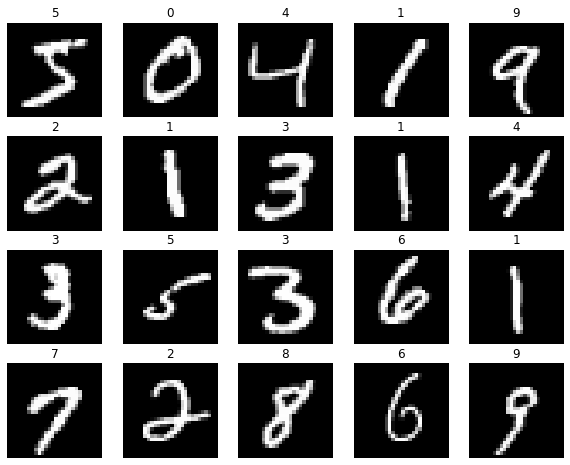

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

#画像のサイズ設定
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i+1)#subplot番号は1始まり
    plt.imshow(X[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
    plt.title(y[i])

## SGDモデルを用いた学習

In [5]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

### 予測結果の確認

実際に学習データのいくつかを予測し、結果を確認してみる。

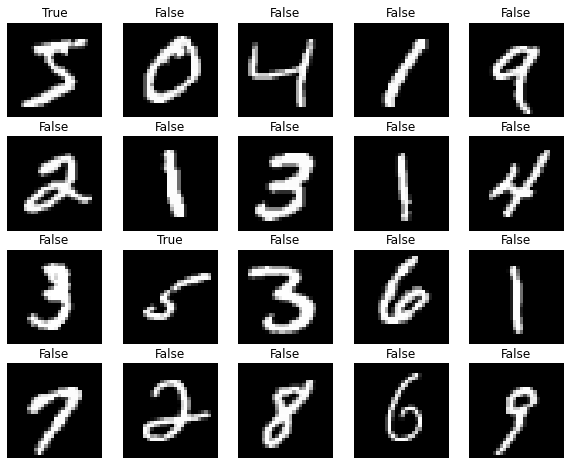

In [6]:
plt.figure(figsize=(10, 8))
for i in range(20):
    label = sgd_clf.predict([X_train[i]])
    label = label[0]#1要素のみのarrayのためboolに変換
    plt.subplot(4, 5, i+1)#subplot番号は1始まり
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
    plt.title(str(label))

## K分割交差検証法を用いた正解率の検証

### K分割交差検証法：  
訓練データをK分割して1つを検証データそれ以外を訓練データとしてモデルを訓練し、その訓練をK回繰り返してモデルを評価する方法。  
訓練データ数が少ない場合はどのデータを訓練データ。検証データにするかで性能が左右されてしまうため、その性能の偏りを無くすことができる。

In [7]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## 混合行列を用いた評価

In [8]:
from pandas import DataFrame
#混合行列の内容についての説明
index = ['真値がFALSEのデータ数', '真値がTRUEのデータ数']
columns = ['予測でFALSEと判断したデータ数', '予測でTRUEと判断したデータ数']
DataFrame([['TN (True Negative 真陰性)', 'FP (False Positive 偽陽性)'],['FN (False Negative 偽陰性)', 'TP (Ture Positive 真陽性)']], index=index, columns= columns)

,予測でFALSEと判断したデータ数,予測でTRUEと判断したデータ数
真値がFALSEのデータ数,TN (True Negative 真陰性),FP (False Positive 偽陽性)
真値がTRUEのデータ数,FN (False Negative 偽陰性),TP (Ture Positive 真陽性)


In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_pred)

index = ['真値がFALSEのデータ数', '真値がTRUEのデータ数']
columns = ['予測でFALSEと判断したデータ数', '予測でTRUEと判断したデータ数']
DataFrame(cm, index=index, columns= columns)

,予測でFALSEと判断したデータ数,予測でTRUEと判断したデータ数
真値がFALSEのデータ数,53892,687
真値がTRUEのデータ数,1891,3530


## 適合率・再現率・F1値を用いた評価

### 適合率：  
モデルがPositive(True)と判断したデータの内、真値がPositive(True)の割合を示す。モデルがPositive(True)と判断した時のその予測の確からしさを表している。  
モデルがNegative(False)と判断した時の確からしさについては無視している。  
$$
Precision Score = \frac{TP}{TP + FP}
$$

### 再現率：  
真値がPositive(True)のデータの内、モデルがPositive(True)と判断した割合を示す。真値がPositive(True)のデータをモデルがどの程度予測できたか表している。  
真値がNegative(False)のデータをPositive(True)と誤検出した割合については無視している。
$$
Recall Score = \frac{TP}{TP + FN}
$$


### F1値：  
適合率と再現率の調和平均。F1値で上記2つの指標を網羅した性能比較を行うときに便利。
$$
F1 Score = \frac{2}{\frac{1}{Precision Score} + \frac{1}{Recall Score}}
$$


In [10]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

print('Precision score : ', precision_score(y_train_5, y_train_pred))
print('Recall score : ', recall_score(y_train_5, y_train_pred))
print('F1 score : ', f1_score(y_train_5, y_train_pred))

Precision score :  0.8370879772350012
Recall score :  0.6511713705958311
F1 score :  0.7325171197343846


## Thresholdを用いた適合率・再現率の調整

適合率と再現率はトレードオフの関係にあり、片方の値を上げようとするともう片方の値は下がってしまう。  
そのため作成するモデルのに合わせて適合率・再現率の値をThresholdを用いて調整が必要となる。

はじめに、Threshold毎の適合率・再現率を確認する。

(-50000.0, 50000.0, 0.0, 1.0)

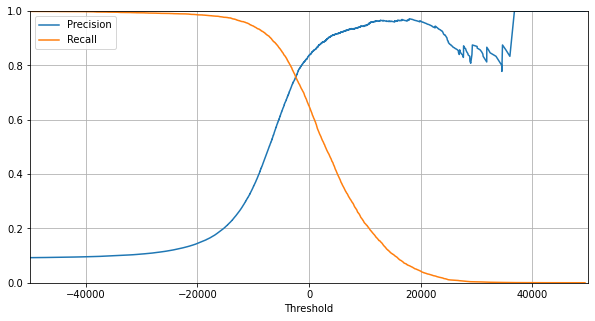

In [11]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.legend()
plt.xlabel("Threshold")
plt.grid(True)
plt.axis([-50000, 50000, 0, 1])

表のように適合率・再現率は背反関係となる。  

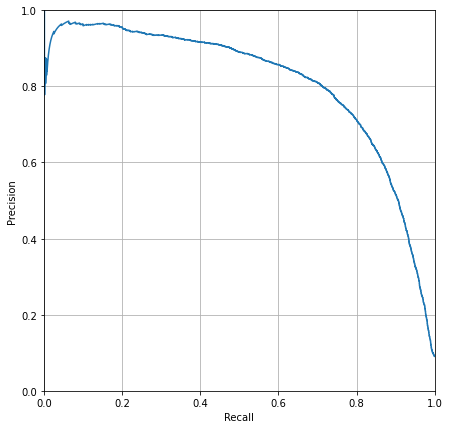

In [12]:
plt.figure(figsize=(7, 7))
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid(True)

今回は適合率Precisionが90%となるモデルに調整を行うこととする。
その際に再現率がどの程度になるのかも確認する。

In [13]:
#Precisionが90%以上になる最初のthresholdを探す
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print('Threshold 90 precision : ', threshold_90_precision)

y_train_pred_90 = (y_scores >= threshold_90_precision)

#Precision 90%に調整したときのスコアを計算
print('Precision score : ', precision_score(y_train_5, y_train_pred_90))
print('Recall score : ', recall_score(y_train_5, y_train_pred_90))

Threshold 90 precision :  3370.0194991439557
Precision score :  0.9000345901072293
Recall score :  0.4799852425751706


## ROC曲線を用いた評価

偽陽性率(FPR)に対する真陽性率(TPR)の値。  
ROC曲線を用いたモデルの比較を行う際にはROC曲線下の面積を示すAUC(Area Under the Curve)を用いる。  
AUCは0～1の範囲を取る。

### 偽陽性率 FPR(False Positive Rasio):
誤ってPositive(True)と判断されたNegative(False)の割合

### 真陽性率 TPR(True Positive Rasio):
再現率と同等

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]

グラフにも示すように再現率 TPRが上がるほど偽陽性率 FPRも上がる。

roc_auc_score :  0.9604938554008616


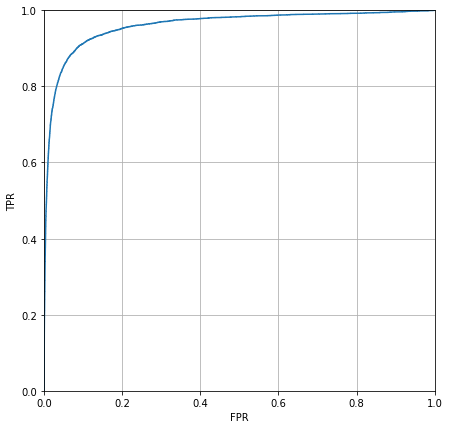

In [15]:
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr)
plt.axis([0, 1, 0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)

print('roc_auc_score : ', roc_auc_score(y_train_5, y_scores))

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

## ランダムフォレストとの比較

SGDとランダムフォレストのROC曲線をグラフ描画する。  
グラフの値ががより左上にある方がより良いモデルとなる。

In [16]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]#Positiveのみ抽出
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

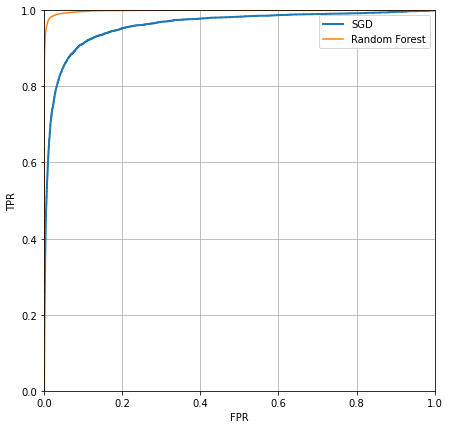

SGD ROC AUC Score :  0.9604938554008616
Random Forest ROC AUC Score :  0.9983436731328145


In [17]:
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.axis([0, 1, 0, 1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid(True)
plt.legend()
plt.show()

print('SGD ROC AUC Score : ', roc_auc_score(y_train_5, y_scores))
print('Random Forest ROC AUC Score : ', roc_auc_score(y_train_5, y_scores_forest))